In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import InputLayer, Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_PATH = './ShenZhen'
TRAIN_PATH = f'{DATA_PATH}/train'
VALID_PATH = f'{DATA_PATH}/valid'
TEST_PATH = f'{DATA_PATH}/test'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
MAX_ACC = 0.97
BASE_LEARNING_RATE = 0.0001
VALID_RATIO = 0.1

# Load dataset

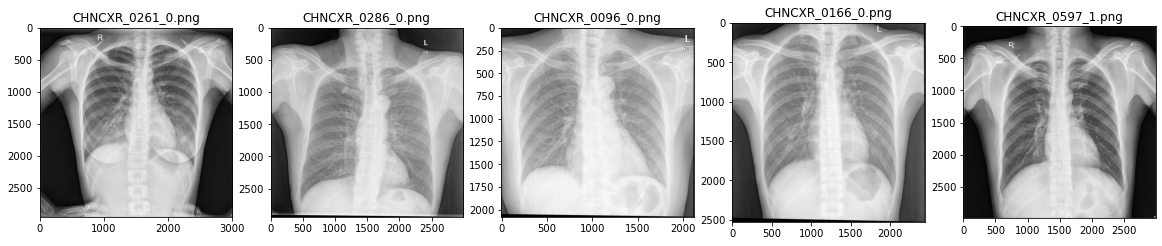

In [3]:
plt.figure(figsize=(20,20))
test_folder=r'D:\FourthYear\GraduateThesis\Abnormal-detection-on-chest-x-ray\ShenZhen\images'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [4]:
data = pd.read_csv(f'{DATA_PATH}/shenzhen_metadata.csv')
del data["sex"]
del data["age"]
data['normal'] = 0
data['abnormal'] = 0
data = data.rename(columns = {'findings':'status'})
for i in data.index:
    if data['status'][i] == 'normal':
        data['normal'][i] = 1
    else:
        data['abnormal'][i] = 1
del data["status"]
patient_status = list(data)[1:]
data

<ipython-input-4-8e15cdcc3112>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normal'][i] = 1
<ipython-input-4-8e15cdcc3112>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['abnormal'][i] = 1


,study_id,normal,abnormal
0,CHNCXR_0001_0.png,1,0
1,CHNCXR_0002_0.png,1,0
2,CHNCXR_0003_0.png,1,0
3,CHNCXR_0004_0.png,1,0
4,CHNCXR_0005_0.png,1,0
...,...,...,...
657,CHNCXR_0658_1.png,0,1
658,CHNCXR_0659_1.png,0,1
659,CHNCXR_0660_1.png,0,1
660,CHNCXR_0661_1.png,0,1


# Visualize dataset

Text(1, 336, '336')

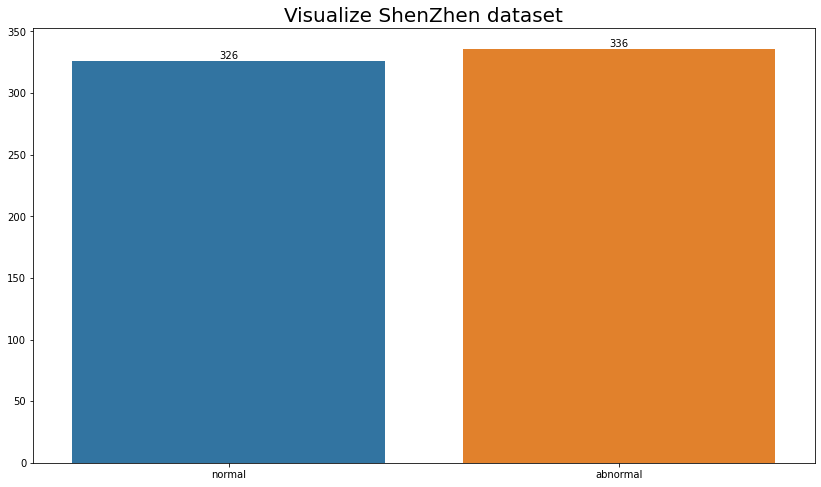

In [5]:
counter = []
fig, ax = plt.subplots(figsize =(14, 8))
#plt.figure(figsize=(15,8))
plt.title("Visualize ShenZhen dataset", fontsize=20)
for i in patient_status:
    counter.append(data[data[i]==1].count().study_id)

sns.barplot(x = patient_status, y = counter)
plt.text(0,counter[0],counter[0],ha="center",va="bottom")
plt.text(1,counter[1],counter[1],ha="center",va="bottom")


# Split training data

In [6]:
if os.path.isdir(TRAIN_PATH) is False:
    # Create train, valid, test folders
    os.mkdir(TRAIN_PATH)
    os.mkdir(VALID_PATH)
    os.mkdir(TEST_PATH)

    train, test = train_test_split(data, test_size = 0.2)

    # Copy test images to test folder
    #test_images = test.study_id.values
    #for img_id in test_images:
    #  shutil.copy(f'{DATA_PATH}/images/{img_id}', TEST_PATH)

    #Create (normal, abnormal) folder
    for i in patient_status:
      os.mkdir(f'{TRAIN_PATH}/{i}')
      os.mkdir(f'{VALID_PATH}/{i}')
      os.mkdir(f'{TEST_PATH}/{i}')

      train_img = train[train[i]==1].study_id.values
      #split train, valid
      train_id, valid_id = train_test_split(train_img, test_size = VALID_RATIO)

      #Copy train images to train folder
      for img_id in train_id:
        shutil.copy(f'{DATA_PATH}/images/{img_id}', f'{TRAIN_PATH}/{i}')

      # Copy validation images to validation folder
      for img_id in valid_id:
        shutil.copy(f'{DATA_PATH}/images/{img_id}', f'{VALID_PATH}/{i}')

      test_img = test[test[i]==1].study_id.values
      #Copy test images to test folder
      for img_id in test_img:
        shutil.copy(f'{DATA_PATH}/images/{img_id}', f'{TEST_PATH}/{i}')
    

# Create data batches

In [7]:
from keras_applications.resnet import ResNet50  

train_datagen = ImageDataGenerator(rescale=1/255,
                                        width_shift_range=.2,
                                        height_shift_range=.2,
                                        brightness_range=[0.5,1],
                                        horizontal_flip=True,
                                        fill_mode='nearest')
train_data = train_datagen.flow_from_directory(TRAIN_PATH,
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')
N_TRAIN_SAMPLE = train_data.samples

valid_datagen = ImageDataGenerator(rescale=1/255,
                                        width_shift_range=.2,
                                        height_shift_range=.2,
                                        brightness_range=[0.5,0.1],
                                        horizontal_flip=True,
                                        fill_mode='nearest')
valid_data = valid_datagen.flow_from_directory(VALID_PATH,
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')
N_VALID_SAMPLE = valid_data.samples

test_datagen = ImageDataGenerator(rescale=1/255)
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')
N_TEST_SAMPLE = test_data.samples

Found 475 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


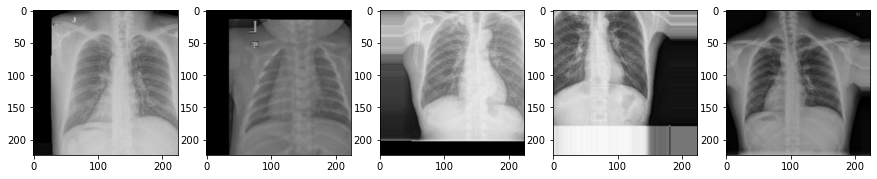

In [8]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
 
for i in range(5):
    img, label = train_data.next()
    print(img.shape)
    axs[i].imshow(img[0])

# Init Model

In [9]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE
)


resnet_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(2, activation='softmax')
])

resnet_model.trainable = True

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
 dense_1 (Dense)             (None, 2)                 6

In [10]:
# define a callback class
class myCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        if logs.get('accuracy') >= MAX_ACC:
            print(f'accuracy reached {MAX_ACC * 100}%. Stop learning')
            self.model.stop_training = True

callback = myCallBacks()

In [11]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE/10),
              loss=['sparse_categorical_crossentropy'],
              metrics=['accuracy']) 

resnet_model.fit(train_data,
          steps_per_epoch=(N_TRAIN_SAMPLE//BATCH_SIZE),
          epochs=30,
          validation_data = valid_data,
          validation_steps=(N_VALID_SAMPLE//BATCH_SIZE),
          callbacks=[callback])

Epoch 1/30
14/14 [==============================] - 206s 14s/step - loss: 0.6860 - accuracy: 0.5305 - val_loss: 0.7026 - val_accuracy: 0.4688
Epoch 2/30
14/14 [==============================] - 215s 15s/step - loss: 0.6805 - accuracy: 0.6072 - val_loss: 0.6788 - val_accuracy: 0.5938
Epoch 3/30
14/14 [==============================] - 206s 15s/step - loss: 0.6823 - accuracy: 0.6117 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 4/30
14/14 [==============================] - 218s 16s/step - loss: 0.6608 - accuracy: 0.6614 - val_loss: 0.7929 - val_accuracy: 0.4062
Epoch 5/30
14/14 [==============================] - 204s 14s/step - loss: 0.6164 - accuracy: 0.7088 - val_loss: 0.7561 - val_accuracy: 0.5312
Epoch 6/30
14/14 [==============================] - 197s 14s/step - loss: 0.5646 - accuracy: 0.7720 - val_loss: 0.8673 - val_accuracy: 0.4375
Epoch 7/30
10/14 [====================>.........] - ETA: 56s - loss: 0.4895 - accuracy: 0.7688 

KeyboardInterrupt: 

In [ ]:
resnet_model.pop()
resnet_model.pop()
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_model.trainable = False
preds = resnet_model.predict(train_data)
preds.shape

(475, 2048)

In [ ]:
import math

number_of_examples = len(test_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 


test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data[i][1]))

In [ ]:
import math

number_of_examples = len(train_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * BATCH_SIZE)) 


train_labels = []

for i in range(0,int(number_of_generator_calls)):
    train_labels.extend(np.array(train_data[i][1]))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier(n_estimators=20,random_state=0)
ab_model.fit(preds, train_labels)
importances = ab_model.feature_importances_

In [ ]:
for i in importances:
    print(i, end=' ')

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.05 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [ ]:
select_features = []
for i in range(len(importances)):
  if importances[i] != 0:
    select_features.append(i)
  
len(select_features)

20

In [ ]:
new_preds = []
for img in preds:
  features = []
  for j in select_features:
    features.append(img[j])
  new_preds.append(features)

resnet_preds = np.array(new_preds)
resnet_preds.shape

(475, 20)

In [ ]:
from sklearn import svm

rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.kernel

'rbf'

In [ ]:
rbf_svc.fit(resnet_preds, train_labels)
predictions = rbf_svc.predict(resnet_preds)
predictions

array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1.

In [ ]:
preds = resnet_model.predict(test_data)

select_features = []
for i in range(len(importances)):
  if importances[i] != 0:
    select_features.append(i)

new_preds = []
for img in preds:
  features = []
  for j in select_features:
    features.append(img[j])
  new_preds.append(features)

resnet_preds = np.array(new_preds)

predictions = rbf_svc.predict(resnet_preds)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
count = 0
for i in range(len(predictions)):
  if predictions[i] == test_labels[i]:
    count = count + 1

acc = count / len(test_labels)
acc

0.556390977443609

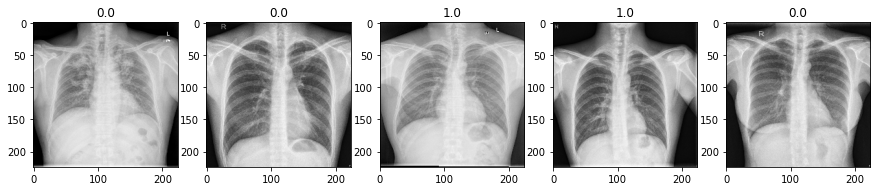

In [ ]:
if predictions[0] == 0:
    label = ["normal"]
else: 
    label = ["abnormal"]

for i in range(1,len(predictions)):
    if predictions[i] == 0:
        label.append('normal')
    else:
        label.append('abnormal')

fig, axs = plt.subplots(1,5, figsize=(15,5))
 
for i in range(5):
    img, img_label = test_data.next()
    axs[i].imshow(img[0])
    
    #label bi sai
    axs[i].title.set_text(label[i])